In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
def parse_filename(file_name):
    parts = file_name.split('_')
    metadata = {
        "class_label": parts[3],  
        "gender": parts[4]
    }
    return metadata

In [3]:
def load_dataset(base_dir= '../train', lang='malayalam'):
    dataset = []
    lang_dir = os.path.join(base_dir, lang)
    audio_dir = os.path.join(lang_dir, "audio")
    text_dir = os.path.join(lang_dir, "text")
    text_file = os.path.join(text_dir, [file for file in os.listdir(text_dir) if file.endswith(".xlsx")][0])
    text_df = pd.read_excel(text_file)
    for file in text_df['File Name']:
        if (file + ".wav") in os.listdir(audio_dir):
            metadata = parse_filename(file)
            audio_path = os.path.join(audio_dir, file + ".wav")
            transcript_row = text_df.loc[text_df["File Name"] == file]
            if not transcript_row.empty:
                transcript = transcript_row.iloc[0]["Transcript"]
                class_label_short = transcript_row.iloc[0]["Class Label Short"]
                dataset.append({
                    "audio_path": audio_path,
                    "transcript": transcript,
                    "class_label": class_label_short,
                    "gender": metadata["gender"]
                })
        else:
            transcript_row = text_df.loc[text_df["File Name"] == file]
            if not transcript_row.empty:
                transcript = transcript_row.iloc[0]["Transcript"]
                class_label_short = transcript_row.iloc[0]["Class Label Short"]
                dataset.append({
                    "audio_path": "Nil",
                    "transcript": transcript,
                    "class_label": class_label_short,
                    "gender": "Unknown"
                })
    return pd.DataFrame(dataset)

In [4]:
dataset_df = load_dataset()

In [5]:
data = dataset_df[dataset_df['audio_path'] != 'Nil']
data = dataset_df[dataset_df['audio_path'].apply(os.path.exists)]
data

,audio_path,transcript,class_label,gender
0,../train\malayalam\audio\H_ML_001_C_F_044_001.wav,നമസ്കാരം ഒരു ഒരു പരമ ചെറ്റയുടെ കാര്യമാണ് ഞാൻ പ...,C,F
1,../train\malayalam\audio\H_ML_001_C_F_044_002.wav,ആദ്യം തന്നെ അവൻറെ ഐഡിയുടെ പേര് വരെ ഞാൻ ഇതിനകത്...,C,F
2,../train\malayalam\audio\H_ML_001_C_F_044_003.wav,അവൻറെ ആ ചെറ്റയുടെ ആ പരമനാറിയുടെ പേര്,C,F
3,../train\malayalam\audio\H_ML_001_C_F_044_004.wav,അവന്റെ ദുഷിച്ച മനസ്സ് കൊണ്ടുവന്ന് എൻറെ വീഡിയോയ...,C,F
4,../train\malayalam\audio\H_ML_001_C_F_044_005.wav,നിൻറെ ദുഷിപ്പ് എല്ലാം എന്തിനാ എന്റെ നേർക്ക് തീ...,C,F
...,...,...,...,...
878,../train\malayalam\audio\NH_ML_002_N_M_014_069...,ഒന്നിനെയും കൂടുതൽ ആശ്രയിക്കാതെ ഇരിക്കുക ഒരിക്ക...,N,M
879,../train\malayalam\audio\NH_ML_002_N_M_014_070...,പിന്തുടർച്ച ഇല്ലാത്ത പ്രവർത്തികൾക്ക് ഒന്നും യാ...,N,M
880,../train\malayalam\audio\NH_ML_002_N_M_014_071...,ഏറ്റവും അടുപ്പമുള്ളവരാണ് അതിസമർഥമായി ചതിക്കുന്...,N,M
881,../train\malayalam\audio\NH_ML_002_N_M_014_072...,സാഹചര്യം ഏതായാലും കീടങ്ങള് വേണ്ടയോ എന്ന് തീരുമ...,N,M


In [6]:
data['audio_path'] = data['audio_path'].str.replace('\\', '/', regex=False)
data

,audio_path,transcript,class_label,gender
0,../train/malayalam/audio/H_ML_001_C_F_044_001.wav,നമസ്കാരം ഒരു ഒരു പരമ ചെറ്റയുടെ കാര്യമാണ് ഞാൻ പ...,C,F
1,../train/malayalam/audio/H_ML_001_C_F_044_002.wav,ആദ്യം തന്നെ അവൻറെ ഐഡിയുടെ പേര് വരെ ഞാൻ ഇതിനകത്...,C,F
2,../train/malayalam/audio/H_ML_001_C_F_044_003.wav,അവൻറെ ആ ചെറ്റയുടെ ആ പരമനാറിയുടെ പേര്,C,F
3,../train/malayalam/audio/H_ML_001_C_F_044_004.wav,അവന്റെ ദുഷിച്ച മനസ്സ് കൊണ്ടുവന്ന് എൻറെ വീഡിയോയ...,C,F
4,../train/malayalam/audio/H_ML_001_C_F_044_005.wav,നിൻറെ ദുഷിപ്പ് എല്ലാം എന്തിനാ എന്റെ നേർക്ക് തീ...,C,F
...,...,...,...,...
878,../train/malayalam/audio/NH_ML_002_N_M_014_069...,ഒന്നിനെയും കൂടുതൽ ആശ്രയിക്കാതെ ഇരിക്കുക ഒരിക്ക...,N,M
879,../train/malayalam/audio/NH_ML_002_N_M_014_070...,പിന്തുടർച്ച ഇല്ലാത്ത പ്രവർത്തികൾക്ക് ഒന്നും യാ...,N,M
880,../train/malayalam/audio/NH_ML_002_N_M_014_071...,ഏറ്റവും അടുപ്പമുള്ളവരാണ് അതിസമർഥമായി ചതിക്കുന്...,N,M
881,../train/malayalam/audio/NH_ML_002_N_M_014_072...,സാഹചര്യം ഏതായാലും കീടങ്ങള് വേണ്ടയോ എന്ന് തീരുമ...,N,M


In [7]:
SAMPLE_RATE = 22050  
DURATION = 3  
MFCC_FEATURES = 40  
def extract_features(file_path, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE):
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [8]:
data['features'] = data['audio_path'].apply(lambda x: extract_features(x))
data = data.dropna(subset=['features'])
label_encoder = LabelEncoder()
data['class_label_encoded'] = label_encoder.fit_transform(data['class_label'])

In [9]:
X = np.array(data['features'].tolist())
y = tf.keras.utils.to_categorical(data['class_label_encoded'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_train = np.expand_dims(X_train, axis=-1) 
X_test = np.expand_dims(X_test, axis=-1)

In [10]:
X_train

array([[[[-1.4735689e+02]],

        [[ 1.3551811e+02]],

        [[ 1.1920015e+01]],

        ...,

        [[-2.7123861e+00]],

        [[-6.0056996e-01]],

        [[ 1.0461503e+00]]],


       [[[-4.7500202e+01]],

        [[ 7.0730545e+01]],

        [[-2.1958160e+01]],

        ...,

        [[ 6.6375666e+00]],

        [[ 2.2501628e+00]],

        [[ 5.2624965e+00]]],


       [[[-8.9478218e+01]],

        [[ 4.8839512e+01]],

        [[-1.4417529e+01]],

        ...,

        [[ 1.0336711e+00]],

        [[-6.9274693e+00]],

        [[-3.5468857e+00]]],


       ...,


       [[[-2.1412433e+02]],

        [[ 1.2739966e+02]],

        [[-1.8596626e+01]],

        ...,

        [[-3.0109136e+00]],

        [[-4.9504619e+00]],

        [[-3.0706365e+00]]],


       [[[-4.2929958e+01]],

        [[ 5.9648834e+01]],

        [[-2.1080318e+01]],

        ...,

        [[ 2.4188504e+00]],

        [[-1.0953687e+00]],

        [[-4.1860417e-01]]],


       [[[-2.5444919e+02]],

       

In [11]:
model = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(MFCC_FEATURES, 1, 1)),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

d:\Multimodal_Hate_Speech_Detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,645 (283.77 KB)

 Trainable params: 72,645 (283.77 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.2)

Epoch 1/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2413 - loss: 7.5916 - val_accuracy: 0.5493 - val_loss: 1.2628
Epoch 2/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3367 - loss: 2.7284 - val_accuracy: 0.5704 - val_loss: 1.2073
Epoch 3/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4228 - loss: 1.7332 - val_accuracy: 0.6197 - val_loss: 1.2198
Epoch 4/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5088 - loss: 1.4114 - val_accuracy: 0.6056 - val_loss: 1.2120
Epoch 5/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5393 - loss: 1.3226 - val_accuracy: 0.6197 - val_loss: 1.1471
Epoch 6/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5561 - loss: 1.2480 - val_accuracy: 0.6690 - val_loss: 1.1191
Epoch 7/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5623 - loss: 1.2923 - val_accuracy: 0.6479 - val_loss: 1.0719
Epoch 8/250
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5780 - loss: 1.2421 - val_accuracy: 0.

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8409 - loss: 0.7909 
Test Accuracy: 84.75%


In [14]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           C       0.87      0.93      0.90        42
           G       0.89      0.89      0.89         9
           N       0.94      1.00      0.97        74
           P       0.69      0.67      0.68        33
           R       0.58      0.37      0.45        19

    accuracy                           0.85       177
   macro avg       0.79      0.77      0.78       177
weighted avg       0.83      0.85      0.84       177



In [15]:
model.save("../models/malayalam_audio_classification_model_without_preprocessing.h5")

In [16]:
np.save("../label encoder/mal_label_encoder_classes.npy", label_encoder.classes_)

With TTSAudioNormalizer and DynamicAudioNormalizer

In [17]:
def tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=0.0):
    target_amplitude = 10 ** (target_peak / 20)
    current_peak = np.max(np.abs(audio))
    if current_peak > 0:
        normalization_factor = target_amplitude / current_peak
    else:
        normalization_factor = 1.0
    normalized_audio = audio * normalization_factor
    gain_amplitude = 10 ** (gain_dB / 20)
    normalized_audio = normalized_audio * gain_amplitude
    return normalized_audio
def dynamic_audio_normalizer(audio, sr):
    peak = np.max(np.abs(audio))
    if peak > 0:
        return audio / peak
    return audio

Original Audio:


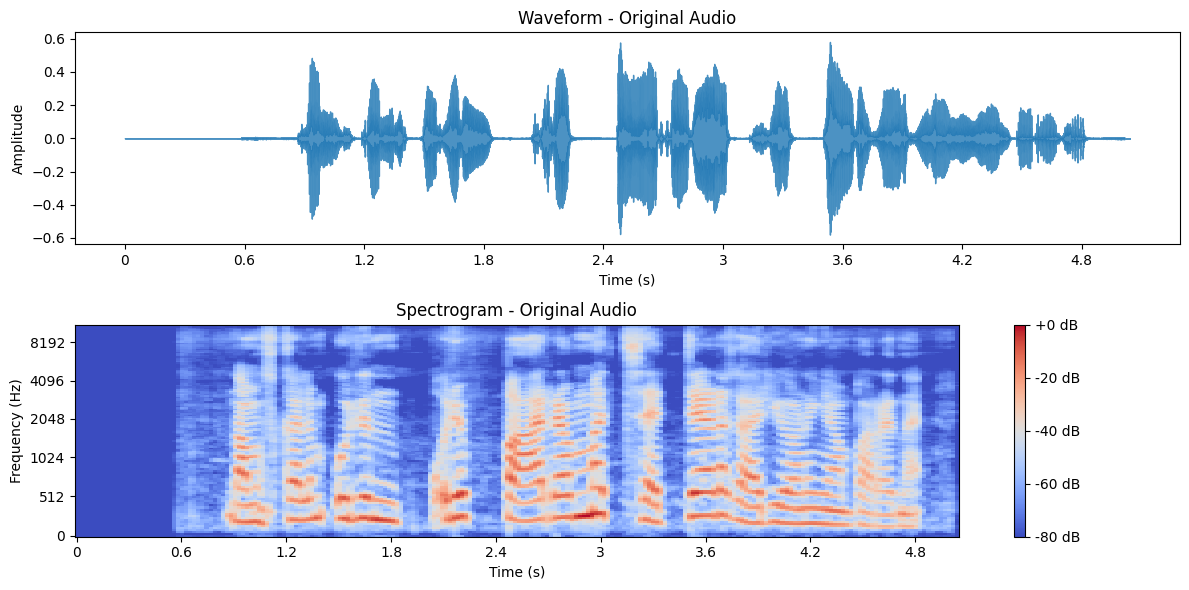

Normalized Audio:


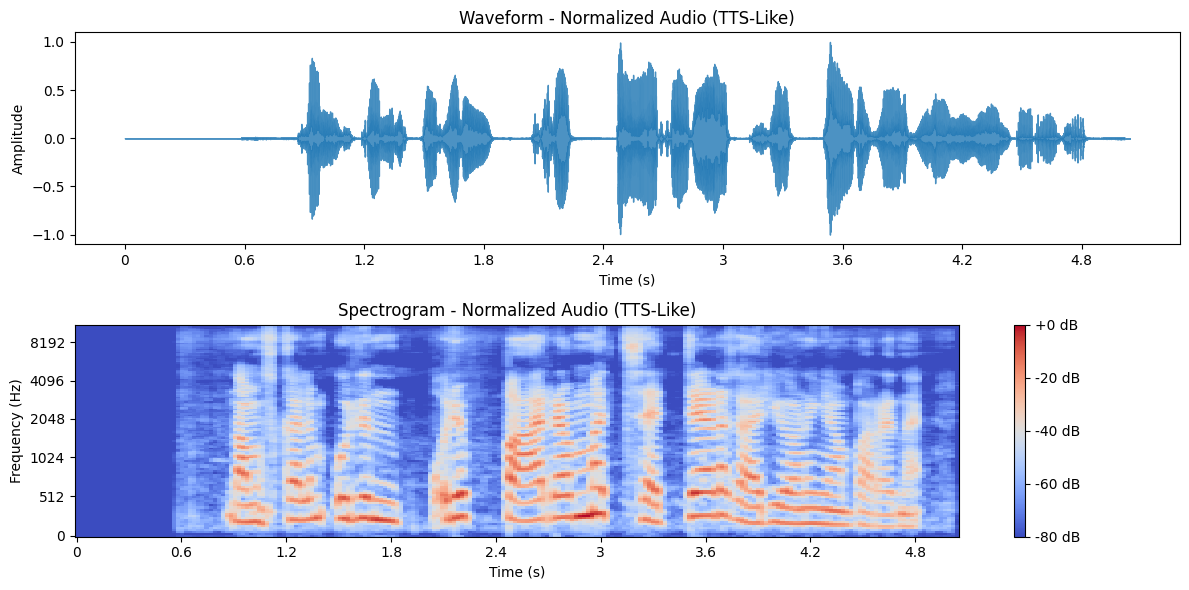

In [19]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
def plot_spectrogram(audio, sr, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio, sr=sr, alpha=0.8)
    plt.title(f"Waveform - {title}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.subplot(2, 1, 2)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram - {title}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()
file_path = "../train/malayalam/audio/H_ML_001_C_F_044_001.wav" 
SAMPLE_RATE = 22050
audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
print("Original Audio:")
plot_spectrogram(audio, sr, "Original Audio")
display(Audio(audio, rate=sr))
normalized_audio = tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=3.0)
normalized_audio = dynamic_audio_normalizer(normalized_audio, sr)
print("Normalized Audio:")
plot_spectrogram(normalized_audio, sr, "Normalized Audio (TTS-Like)")
display(Audio(normalized_audio, rate=sr))

In [20]:
def extract_features(file_path, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE):
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        normalized_audio = tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=3.0)
        normalized_audio = dynamic_audio_normalizer(normalized_audio, sr)
        mfccs = librosa.feature.mfcc(y=normalized_audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)  
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [21]:
data['processed features'] = data['audio_path'].apply(lambda x: extract_features(x))

In [22]:
data

,audio_path,transcript,class_label,gender,features,class_label_encoded,processed features
0,../train/malayalam/audio/H_ML_001_C_F_044_001.wav,നമസ്കാരം ഒരു ഒരു പരമ ചെറ്റയുടെ കാര്യമാണ് ഞാൻ പ...,C,F,"[-353.01236, 73.07126, -9.8245945, -5.5852184,...",0,"[-298.84418, 73.07126, -9.8245945, -5.5852184,..."
1,../train/malayalam/audio/H_ML_001_C_F_044_002.wav,ആദ്യം തന്നെ അവൻറെ ഐഡിയുടെ പേര് വരെ ഞാൻ ഇതിനകത്...,C,F,"[-289.59833, 85.15918, -32.192276, 8.961157, 1...",0,"[-231.19092, 85.15918, -32.192276, 8.961158, 1..."
2,../train/malayalam/audio/H_ML_001_C_F_044_003.wav,അവൻറെ ആ ചെറ്റയുടെ ആ പരമനാറിയുടെ പേര്,C,F,"[-294.83365, 99.79523, -30.36005, 0.6052273, 5...",0,"[-222.9003, 99.795235, -30.36005, 0.6052265, 5..."
3,../train/malayalam/audio/H_ML_001_C_F_044_004.wav,അവന്റെ ദുഷിച്ച മനസ്സ് കൊണ്ടുവന്ന് എൻറെ വീഡിയോയ...,C,F,"[-247.0347, 69.055916, -13.098228, 7.6583233, ...",0,"[-167.24646, 69.055916, -13.0982275, 7.6583242..."
4,../train/malayalam/audio/H_ML_001_C_F_044_005.wav,നിൻറെ ദുഷിപ്പ് എല്ലാം എന്തിനാ എന്റെ നേർക്ക് തീ...,C,F,"[-264.99805, 89.194664, -23.205296, 7.782707, ...",0,"[-198.8844, 89.19467, -23.205296, 7.7827063, 1..."
...,...,...,...,...,...,...,...
878,../train/malayalam/audio/NH_ML_002_N_M_014_069...,ഒന്നിനെയും കൂടുതൽ ആശ്രയിക്കാതെ ഇരിക്കുക ഒരിക്ക...,N,M,"[-266.09668, 114.15903, 7.8388677, 25.115265, ...",2,"[-265.99942, 114.15903, 7.838868, 25.115265, -..."
879,../train/malayalam/audio/NH_ML_002_N_M_014_070...,പിന്തുടർച്ച ഇല്ലാത്ത പ്രവർത്തികൾക്ക് ഒന്നും യാ...,N,M,"[-292.04892, 102.66058, 14.483307, 18.129362, ...",2,"[-291.51703, 102.66058, 14.483304, 18.129362, ..."
880,../train/malayalam/audio/NH_ML_002_N_M_014_071...,ഏറ്റവും അടുപ്പമുള്ളവരാണ് അതിസമർഥമായി ചതിക്കുന്...,N,M,"[-272.64243, 122.13123, 0.56272125, 26.690296,...",2,"[-272.71478, 122.131226, 0.5627236, 26.690294,..."
881,../train/malayalam/audio/NH_ML_002_N_M_014_072...,സാഹചര്യം ഏതായാലും കീടങ്ങള് വേണ്ടയോ എന്ന് തീരുമ...,N,M,"[-204.90053, 126.601715, -9.844121, 36.109516,...",2,"[-206.64345, 126.601715, -9.844123, 36.10952, ..."


In [23]:
data = data.dropna(subset=['processed features'])

In [24]:
data

,audio_path,transcript,class_label,gender,features,class_label_encoded,processed features
0,../train/malayalam/audio/H_ML_001_C_F_044_001.wav,നമസ്കാരം ഒരു ഒരു പരമ ചെറ്റയുടെ കാര്യമാണ് ഞാൻ പ...,C,F,"[-353.01236, 73.07126, -9.8245945, -5.5852184,...",0,"[-298.84418, 73.07126, -9.8245945, -5.5852184,..."
1,../train/malayalam/audio/H_ML_001_C_F_044_002.wav,ആദ്യം തന്നെ അവൻറെ ഐഡിയുടെ പേര് വരെ ഞാൻ ഇതിനകത്...,C,F,"[-289.59833, 85.15918, -32.192276, 8.961157, 1...",0,"[-231.19092, 85.15918, -32.192276, 8.961158, 1..."
2,../train/malayalam/audio/H_ML_001_C_F_044_003.wav,അവൻറെ ആ ചെറ്റയുടെ ആ പരമനാറിയുടെ പേര്,C,F,"[-294.83365, 99.79523, -30.36005, 0.6052273, 5...",0,"[-222.9003, 99.795235, -30.36005, 0.6052265, 5..."
3,../train/malayalam/audio/H_ML_001_C_F_044_004.wav,അവന്റെ ദുഷിച്ച മനസ്സ് കൊണ്ടുവന്ന് എൻറെ വീഡിയോയ...,C,F,"[-247.0347, 69.055916, -13.098228, 7.6583233, ...",0,"[-167.24646, 69.055916, -13.0982275, 7.6583242..."
4,../train/malayalam/audio/H_ML_001_C_F_044_005.wav,നിൻറെ ദുഷിപ്പ് എല്ലാം എന്തിനാ എന്റെ നേർക്ക് തീ...,C,F,"[-264.99805, 89.194664, -23.205296, 7.782707, ...",0,"[-198.8844, 89.19467, -23.205296, 7.7827063, 1..."
...,...,...,...,...,...,...,...
878,../train/malayalam/audio/NH_ML_002_N_M_014_069...,ഒന്നിനെയും കൂടുതൽ ആശ്രയിക്കാതെ ഇരിക്കുക ഒരിക്ക...,N,M,"[-266.09668, 114.15903, 7.8388677, 25.115265, ...",2,"[-265.99942, 114.15903, 7.838868, 25.115265, -..."
879,../train/malayalam/audio/NH_ML_002_N_M_014_070...,പിന്തുടർച്ച ഇല്ലാത്ത പ്രവർത്തികൾക്ക് ഒന്നും യാ...,N,M,"[-292.04892, 102.66058, 14.483307, 18.129362, ...",2,"[-291.51703, 102.66058, 14.483304, 18.129362, ..."
880,../train/malayalam/audio/NH_ML_002_N_M_014_071...,ഏറ്റവും അടുപ്പമുള്ളവരാണ് അതിസമർഥമായി ചതിക്കുന്...,N,M,"[-272.64243, 122.13123, 0.56272125, 26.690296,...",2,"[-272.71478, 122.131226, 0.5627236, 26.690294,..."
881,../train/malayalam/audio/NH_ML_002_N_M_014_072...,സാഹചര്യം ഏതായാലും കീടങ്ങള് വേണ്ടയോ എന്ന് തീരുമ...,N,M,"[-204.90053, 126.601715, -9.844121, 36.109516,...",2,"[-206.64345, 126.601715, -9.844123, 36.10952, ..."


In [25]:
X = np.array(data['processed features'].tolist())
label_encoder = LabelEncoder()
data['class_label_encoded'] = label_encoder.fit_transform(data['class_label'])
y = tf.keras.utils.to_categorical(data['class_label_encoded'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis, np.newaxis]  
X_test = X_test[..., np.newaxis, np.newaxis]

In [27]:
norm_model = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(MFCC_FEATURES, 1, 1)),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(128, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])

norm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
norm_model.summary()

d:\Multimodal_Hate_Speech_Detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 1, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,885 (511.27 KB)

 Trainable params: 130,885 (511.27 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = norm_model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)

Epoch 1/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3551 - loss: 3.1674 - val_accuracy: 0.5189 - val_loss: 1.2038
Epoch 2/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4670 - loss: 1.6375 - val_accuracy: 0.6509 - val_loss: 1.1648
Epoch 3/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5633 - loss: 1.2241 - val_accuracy: 0.6981 - val_loss: 1.1453
Epoch 4/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5401 - loss: 1.2532 - val_accuracy: 0.6981 - val_loss: 1.0643
Epoch 5/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5880 - loss: 1.1621 - val_accuracy: 0.6604 - val_loss: 1.0811
Epoch 6/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5893 - loss: 1.1611 - val_accuracy: 0.6698 - val_loss: 1.0543
Epoch 7/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5962 - loss: 1.1361 - val_accuracy: 0.6792 - val_loss: 1.0759
Epoch 8/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5848 - loss: 1.1246 - val_accuracy: 0.6321 - v

In [29]:
test_loss, test_accuracy = norm_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7999 - loss: 0.6225
Test Accuracy: 79.66%


In [30]:
y_pred = norm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

           C       0.79      0.88      0.83        42
           G       0.54      0.78      0.64         9
           N       0.94      1.00      0.97        74
           P       0.74      0.52      0.61        33
           R       0.40      0.32      0.35        19

    accuracy                           0.80       177
   macro avg       0.68      0.70      0.68       177
weighted avg       0.79      0.80      0.79       177



In [31]:
norm_model.save("../models/malayalam_audio_classification_model_with_normalizers.h5")

Data Augmentation

In [32]:
data

,audio_path,transcript,class_label,gender,features,class_label_encoded,processed features
0,../train/malayalam/audio/H_ML_001_C_F_044_001.wav,നമസ്കാരം ഒരു ഒരു പരമ ചെറ്റയുടെ കാര്യമാണ് ഞാൻ പ...,C,F,"[-353.01236, 73.07126, -9.8245945, -5.5852184,...",0,"[-298.84418, 73.07126, -9.8245945, -5.5852184,..."
1,../train/malayalam/audio/H_ML_001_C_F_044_002.wav,ആദ്യം തന്നെ അവൻറെ ഐഡിയുടെ പേര് വരെ ഞാൻ ഇതിനകത്...,C,F,"[-289.59833, 85.15918, -32.192276, 8.961157, 1...",0,"[-231.19092, 85.15918, -32.192276, 8.961158, 1..."
2,../train/malayalam/audio/H_ML_001_C_F_044_003.wav,അവൻറെ ആ ചെറ്റയുടെ ആ പരമനാറിയുടെ പേര്,C,F,"[-294.83365, 99.79523, -30.36005, 0.6052273, 5...",0,"[-222.9003, 99.795235, -30.36005, 0.6052265, 5..."
3,../train/malayalam/audio/H_ML_001_C_F_044_004.wav,അവന്റെ ദുഷിച്ച മനസ്സ് കൊണ്ടുവന്ന് എൻറെ വീഡിയോയ...,C,F,"[-247.0347, 69.055916, -13.098228, 7.6583233, ...",0,"[-167.24646, 69.055916, -13.0982275, 7.6583242..."
4,../train/malayalam/audio/H_ML_001_C_F_044_005.wav,നിൻറെ ദുഷിപ്പ് എല്ലാം എന്തിനാ എന്റെ നേർക്ക് തീ...,C,F,"[-264.99805, 89.194664, -23.205296, 7.782707, ...",0,"[-198.8844, 89.19467, -23.205296, 7.7827063, 1..."
...,...,...,...,...,...,...,...
878,../train/malayalam/audio/NH_ML_002_N_M_014_069...,ഒന്നിനെയും കൂടുതൽ ആശ്രയിക്കാതെ ഇരിക്കുക ഒരിക്ക...,N,M,"[-266.09668, 114.15903, 7.8388677, 25.115265, ...",2,"[-265.99942, 114.15903, 7.838868, 25.115265, -..."
879,../train/malayalam/audio/NH_ML_002_N_M_014_070...,പിന്തുടർച്ച ഇല്ലാത്ത പ്രവർത്തികൾക്ക് ഒന്നും യാ...,N,M,"[-292.04892, 102.66058, 14.483307, 18.129362, ...",2,"[-291.51703, 102.66058, 14.483304, 18.129362, ..."
880,../train/malayalam/audio/NH_ML_002_N_M_014_071...,ഏറ്റവും അടുപ്പമുള്ളവരാണ് അതിസമർഥമായി ചതിക്കുന്...,N,M,"[-272.64243, 122.13123, 0.56272125, 26.690296,...",2,"[-272.71478, 122.131226, 0.5627236, 26.690294,..."
881,../train/malayalam/audio/NH_ML_002_N_M_014_072...,സാഹചര്യം ഏതായാലും കീടങ്ങള് വേണ്ടയോ എന്ന് തീരുമ...,N,M,"[-204.90053, 126.601715, -9.844121, 36.109516,...",2,"[-206.64345, 126.601715, -9.844123, 36.10952, ..."


In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
def augment_audio(audio, sr):
    noise = np.random.randn(len(audio))
    audio_noise = audio + 0.005 * noise
    audio_stretch = librosa.effects.time_stretch(audio, rate=0.8)
    audio_shift = librosa.effects.pitch_shift(audio, sr=sr, n_steps=4)
    return [audio, audio_noise, audio_stretch, audio_shift]
augmented_data = []
def extract_features(audio, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE):
    try:
        normalized_audio = tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=3.0)
        normalized_audio = dynamic_audio_normalizer(normalized_audio, sr)
        mfccs = librosa.feature.mfcc(y=normalized_audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None
for index, row in data.iterrows():
    audio, sr = librosa.load(row['audio_path'], sr=SAMPLE_RATE)
    augmented_audios = augment_audio(audio, sr)
    for aug_audio in augmented_audios:
        features = extract_features(aug_audio, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE)
        if features is not None:
            augmented_data.append({
                'features': features,
                'class_label': row['class_label']
            })

augmented_df = pd.DataFrame(augmented_data)
augmented_df

,features,class_label
0,"[-279.62048, 80.34169, -12.680254, -2.7784307,...",C
1,"[-185.57665076989986, 43.85439983710735, -2.66...",C
2,"[-256.17413, 81.0163, -15.351481, -3.1997674, ...",C
3,"[-267.68942, 74.407845, -29.01455, 1.9543592, ...",C
4,"[-249.13692, 90.6034, -19.625017, 8.174662, 11...",C
...,...,...
3527,"[-239.93475, 115.77389, -4.270232, 28.458944, ...",N
3528,"[-203.60886, 138.87578, -0.2919108, 32.37095, ...",N
3529,"[-161.99694927213608, 102.28479979125065, 14.9...",N
3530,"[-246.2331, 137.66133, -2.0077791, 32.3771, -4...",N


In [34]:
label_encoder = LabelEncoder()
augmented_df['class_label_encoded'] = label_encoder.fit_transform(augmented_df['class_label'])

In [35]:
augmented_df

,features,class_label,class_label_encoded
0,"[-279.62048, 80.34169, -12.680254, -2.7784307,...",C,0
1,"[-185.57665076989986, 43.85439983710735, -2.66...",C,0
2,"[-256.17413, 81.0163, -15.351481, -3.1997674, ...",C,0
3,"[-267.68942, 74.407845, -29.01455, 1.9543592, ...",C,0
4,"[-249.13692, 90.6034, -19.625017, 8.174662, 11...",C,0
...,...,...,...
3527,"[-239.93475, 115.77389, -4.270232, 28.458944, ...",N,2
3528,"[-203.60886, 138.87578, -0.2919108, 32.37095, ...",N,2
3529,"[-161.99694927213608, 102.28479979125065, 14.9...",N,2
3530,"[-246.2331, 137.66133, -2.0077791, 32.3771, -4...",N,2


In [36]:
X_augmented = np.array(augmented_df['features'].tolist())
y_augmented = tf.keras.utils.to_categorical(augmented_df['class_label_encoded'])
X_combined = np.concatenate((X, X_augmented), axis=0)
y_combined = np.concatenate((y, y_augmented), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
X_train = X_train[..., np.newaxis, np.newaxis]
X_test = X_test[..., np.newaxis, np.newaxis]

In [37]:
aug_model = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(MFCC_FEATURES, 1, 1)),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(128, (3, 1), activation='relu'),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])
aug_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aug_model.summary()

d:\Multimodal_Hate_Speech_Detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 38, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 1, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,885 (511.27 KB)

 Trainable params: 130,885 (511.27 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = aug_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4046 - loss: 4.8321 - val_accuracy: 0.6775 - val_loss: 2.8770 - learning_rate: 0.0010
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5712 - loss: 2.7638 - val_accuracy: 0.6902 - val_loss: 2.1094 - learning_rate: 0.0010
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6090 - loss: 2.0813 - val_accuracy: 0.7242 - val_loss: 1.5991 - learning_rate: 0.0010
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6506 - loss: 1.6773 - val_accuracy: 0.7270 - val_loss: 1.3738 - learning_rate: 0.0010
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6854 - loss: 1.3949 - val_accuracy: 0.7581 - val_loss: 1.1682 - learning_rate: 0.0010
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6697 - loss: 1.3187 - val_accuracy: 0.7383 - val_loss: 1.0500 - learning_rate: 0.0010
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6615 - loss: 1.1950 - va

In [39]:
test_loss, test_accuracy = aug_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8920 - loss: 0.3951
Test Accuracy: 90.26%


In [40]:
y_pred = aug_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           C       0.96      0.91      0.93       189
           G       0.82      0.87      0.84        91
           N       0.97      0.99      0.98       387
           P       0.79      0.79      0.79       119
           R       0.73      0.71      0.72        97

    accuracy                           0.90       883
   macro avg       0.85      0.85      0.85       883
weighted avg       0.90      0.90      0.90       883



In [41]:
aug_model.save("../models/malayalam_augmentation_model.h5")

In [42]:
from tensorflow.keras.layers import BatchNormalization
imp_aug_model = Sequential([
    Conv2D(64, (3, 1), activation='relu', input_shape=(MFCC_FEATURES, 1, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(128, (3, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Conv2D(256, (3, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1)),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])
imp_aug_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
imp_aug_model.summary()

d:\Multimodal_Hate_Speech_Detection\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 38, 1, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 19, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 19, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 17, 1, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 1, 256)      │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 3, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,653 (2.00 MB)

 Trainable params: 521,733 (1.99 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('../models/malayalam_best_audio_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
history = imp_aug_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stopping, checkpoint])

Epoch 1/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4863 - loss: 1.7853 - val_accuracy: 0.6591 - val_loss: 0.9418 - learning_rate: 0.0010
Epoch 2/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6513 - loss: 1.1002 - val_accuracy: 0.7412 - val_loss: 0.6897 - learning_rate: 0.0010
Epoch 3/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6910 - loss: 0.9386 - val_accuracy: 0.8402 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 4/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7112 - loss: 0.8140 - val_accuracy: 0.8628 - val_loss: 0.4181 - learning_rate: 0.0010
Epoch 5/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7543 - loss: 0.6952 - val_accuracy: 0.8826 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 6/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7703 - loss: 0.6374 - val_accuracy: 0.8359 - val_loss: 0.3921 - learning_rate: 0.0010
Epoch 7/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7526 - loss: 0.6328 - 

In [45]:
best_model = tf.keras.models.load_model('../models/malayalam_best_audio_model.keras')
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Accuracy: {test_accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9252 - loss: 0.2389
Best Model Test Accuracy: 92.98%


In [46]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           C       0.96      0.95      0.95       189
           G       0.90      0.88      0.89        91
           N       0.99      0.99      0.99       387
           P       0.85      0.83      0.84       119
           R       0.78      0.82      0.80        97

    accuracy                           0.93       883
   macro avg       0.89      0.90      0.89       883
weighted avg       0.93      0.93      0.93       883



In [47]:
X_test.shape

(883, 40, 1, 1)

In [48]:
file_path = "../train/malayalam/audio/H_ML_001_C_F_044_005.wav"
audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
def extract_features(audio, n_mfcc=MFCC_FEATURES, duration=DURATION, sr=SAMPLE_RATE):
    try:
        normalized_audio = tts_audio_normalizer(audio, target_peak=-1.0, gain_dB=3.0)
        normalized_audio = dynamic_audio_normalizer(normalized_audio, sr)
        mfccs = librosa.feature.mfcc(y=normalized_audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

features = extract_features(audio)
features.shape

(40,)

In [50]:
reshaped_features = features.reshape((1, MFCC_FEATURES, 1, 1))
predicted_class = np.argmax(best_model.predict(reshaped_features), axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f"Predicted class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted class: C
